In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import seaborn as sns

Original Training Data Distribution:
Training_Program
0    26
2    24
3    22
1    21
4    18
5    18
6    12
7    11
Name: count, dtype: int64

Training Data Distribution After SMOTE:
Training_Program
7    26
1    26
2    26
4    26
6    26
3    26
5    26
0    26
Name: count, dtype: int64
Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.1685 - loss: 2.2432 - val_accuracy: 0.1905 - val_loss: 2.1120
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0712 - loss: 2.2204 - val_accuracy: 0.2857 - val_loss: 2.0534
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2390 - loss: 2.0277 - val_accuracy: 0.3095 - val_loss: 2.0057
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2506 - loss: 1.8941 - val_accuracy: 0.3810 - val_loss: 1.9688
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3051 - loss: 1.8123 - val_accuracy: 0.4048 - val_loss: 1.9102
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2930 - loss: 

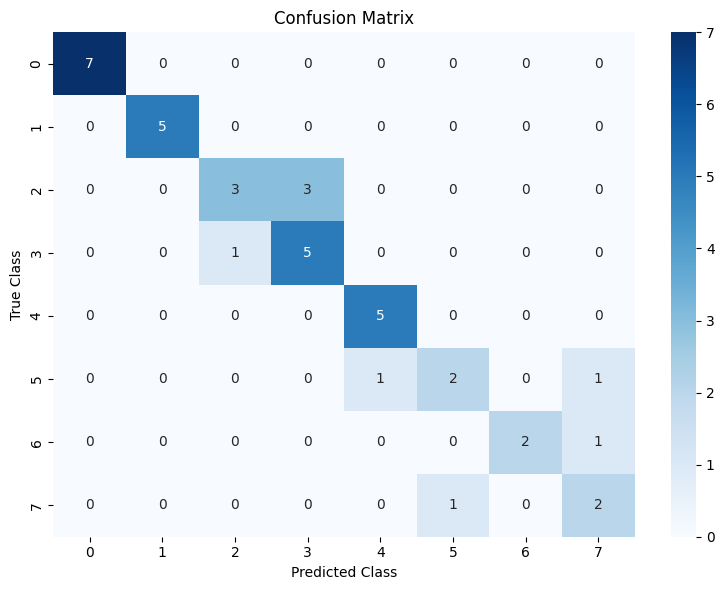

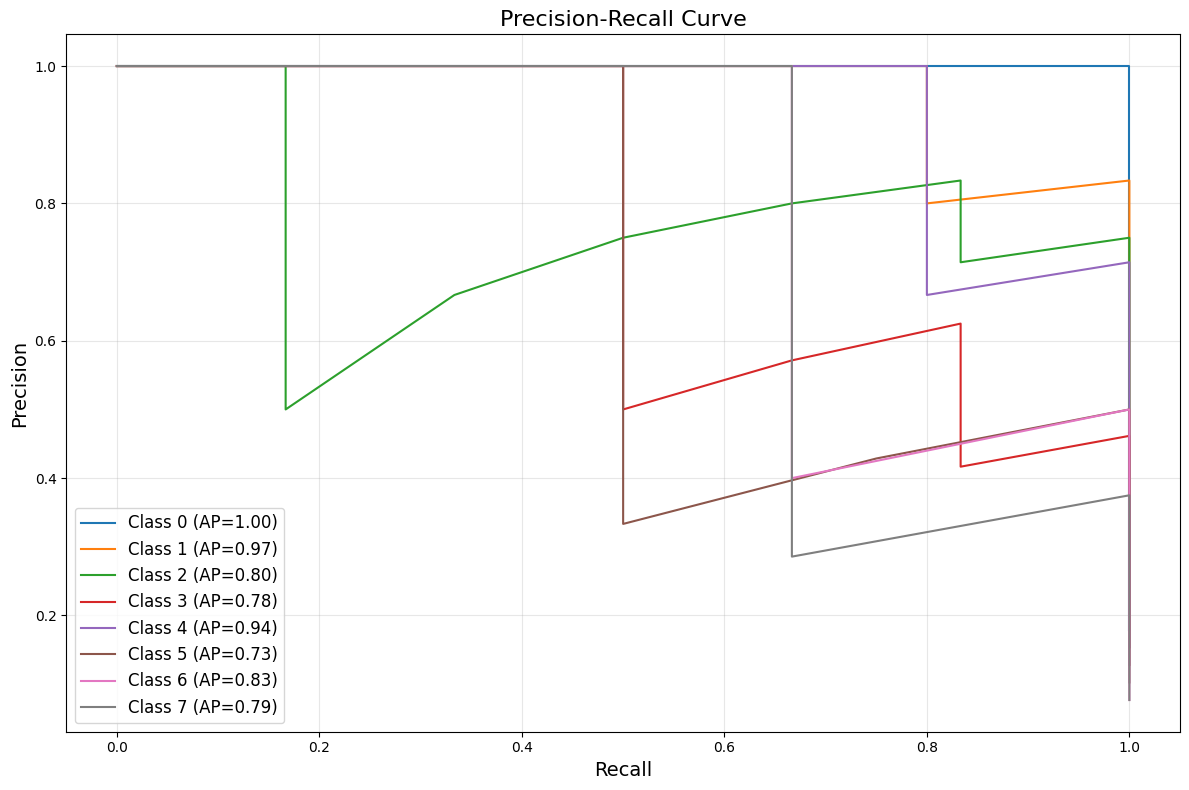


Overall PR AUC (Macro Average): 0.86


In [9]:
# Define a seed for reproducibility
seed = 12 

# Load the dataset
VT = pd.read_csv("data/processed_VT_Data.csv")
pd.set_option('display.max_columns', None)

# Separate features and target variable
X = VT.drop(columns=["Training_Program"])
y = VT["Training_Program"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Generate synthetic data with SMOTE
smote = SMOTE(random_state=seed)  # Use the seed for SMOTE consistency
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original Training Data Distribution:")
print(pd.Series(y_train).value_counts())
print("\nTraining Data Distribution After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# One-hot encode the target variable
y_train_resampled_encoded = to_categorical(y_train_resampled, num_classes=len(y.unique()))
y_test_encoded = to_categorical(y_test, num_classes=len(y.unique()))

# Define the model
model = Sequential([
    Dense(128),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.5),
    Dense(64),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.5),
    Dense(len(y.unique()), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.8),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train_resampled, y_train_resampled_encoded,
    epochs=50,
    batch_size=4,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)

# Print test results
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_test_encoded.argmax(axis=1)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()

# Precision-Recall Curve and PR AUC
# Binarize the true labels (One-vs-Rest approach for multi-class PR Curve)
y_test_binarized = label_binarize(y_true_classes, classes=np.unique(y))
y_pred_probabilities = y_pred  # Probabilities from the softmax layer

# Initialize PR Curve plot
plt.figure(figsize=(12, 8))

# Loop through each class to calculate PR Curve and AUC
for i, class_label in enumerate(np.unique(y)):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_probabilities[:, i])
    auc_score = average_precision_score(y_test_binarized[:, i], y_pred_probabilities[:, i])
    plt.plot(recall, precision, label=f'Class {class_label} (AP={auc_score:.2f})')

# Plot settings
plt.title('Precision-Recall Curve', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate Macro Average PR AUC
overall_pr_auc = average_precision_score(y_test_binarized, y_pred_probabilities, average="macro")
print(f"\nOverall PR AUC (Macro Average): {overall_pr_auc:.2f}")

In [3]:
# Convert the model into a SHAP explainer
explainer = shap.GradientExplainer(model, X_train[:100])

# Özellik bazlı SHAP değerlerini hesapla
shap_values = explainer(X_test[:100])

# SHAP değerlerini DataFrame'e dönüştür ve ortalama mutlak değerlerini hesapla
shap_values_mean = pd.DataFrame(shap_values.values, columns=X.columns).abs().mean().sort_values(ascending=False)

# Özellik önem sırasını tablo olarak çıkar
shap_feature_importance = pd.DataFrame({
    'Feature': shap_values_mean.index,  # Özellik isimleri
    'Mean Absolute SHAP Value': shap_values_mean.values  # Ortalama mutlak SHAP değerleri
})

# İlk 10 özelliği göster
print(shap_feature_importance.head(10))

# Bar grafiği ile görselleştir
plt.figure(figsize=(10, 6))
shap_values_mean.plot(kind='bar')
plt.title("Feature Importance (Mean Absolute SHAP Values)")
plt.xlabel("Features")
plt.ylabel("Mean SHAP Value")
plt.tight_layout()
plt.show()

NameError: name 'shap' is not defined